In [3]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_pickle('/content/drive/My Drive/16k_apperal_data')
image_features=np.load('/content/drive/My Drive/16k_data_cnn_features.npy')
image_features_asin=np.load('/content/drive/My Drive/16k_data_cnn_feature_asins.npy')

image=pd.DataFrame({'asin':image_features_asin,'Image_features':list(image_features)},columns=['asin','Image_features'])
data=data.merge(right=image,on='asin')
data.head()

asin  ...                                     Image_features
0  B004GSI2OS  ...  [0.1865767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1  B012YX2ZPI  ...  [0.6392158, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2  B003BSRPB0  ...  [0.65896046, 0.0, 0.0, 0.0, 0.1555258, 0.0, 0....
3  B014ICEJ1Q  ...  [0.14460832, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
4  B01NACPBG2  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 8 columns]

In [42]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'as', 'further', 'aren', 'were', 'be', 'do', 'haven', 'now', 'an', 'here', 'm', 'to', 'with', 'nor', 'on', 'myself', 'mustn', 'over', 'same', 'yourself', 'yours', 'ourselves', 'theirs', 'couldn', 'hers', 'this', 'him', "aren't", 'whom', "shan't", 'was', 'our', 'because', 'shan', "weren't", 's', 'isn', 'am', 'won', 'own', 'through', 'himself', 'why', 'very', 'up', 'we', 'both', "isn't", 'he', 'been', 'hasn', 'have', "wouldn't", "mightn't", 'off', "didn't", 'few', "hadn't", 'shouldn', 'their', 'does', 'where', 'in', 'she', 'which', 'me', 'don', 'are', 'how', 'between', 'll', 'that', 'each', 'against', 'just', 'some', 'such', "shouldn't", 're', 'can', "hasn't", 't', "should've", 'wasn', 'his', 'during', 'mightn', 'wouldn', "it's", 'should', 'your', 'if', 'before', 'y', "won't", 'those', 'at', 'itself', 'any', 'i', 'once', 'they', "wasn't", 'no', 'until', 'other', 'again', 'did', "you'll", 'but', 'while', 'than', 'hadn', 'out', 'o', 'doing', 'or', "needn't", 'about', '

In [43]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

6.127343000000003 seconds


In [5]:
data=data.dropna()
data.shape

(15989, 8)

## Bow of Brand

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
brands = [x.replace(" ", "-") for x in data['brand'].values]

brand_vectorizer = CountVectorizer()
brand_features   = brand_vectorizer.fit_transform(brands)
brand_features.shape

(15989, 3834)

## Bow of color

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
colors = [x.replace(" ", "-") for x in data['color'].values]
color_vectorizer = CountVectorizer()
color_features   = color_vectorizer.fit_transform(colors)
color_features.shape

(15989, 1842)

## Image_features

In [8]:
from scipy import sparse
image_features=sparse.csr_matrix(list(data['Image_features']))
print(image_features.shape)

(15989, 25088)


## Idf Features

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(use_idf=True)
tfidf_words=tf.fit_transform(data['title'])
idf=tf.idf_
idf_words=tf.get_feature_names()
idf_title_feature=dict(zip(tf.get_feature_names(), idf))

In [0]:
import pickle
with open('/content/drive/My Drive/glove_vectors', 'rb') as handle:
    model = pickle.load(handle)

In [0]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec
count=0
vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  tf.vocabulary_:
                featureVec = np.add(featureVec, idf_title_feature[word] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [60]:
print(len(w2v_title_weight))

15989


In [0]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  tf.vocabulary_:
                print("ENTER")
                vec.append(idf_title_feature[i] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)
def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

In [0]:
def heat_map_w2v_brand(sentance1, sentance2, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, 'weighted')
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, 'weighted')
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)
    plt.show()

# Recommendation

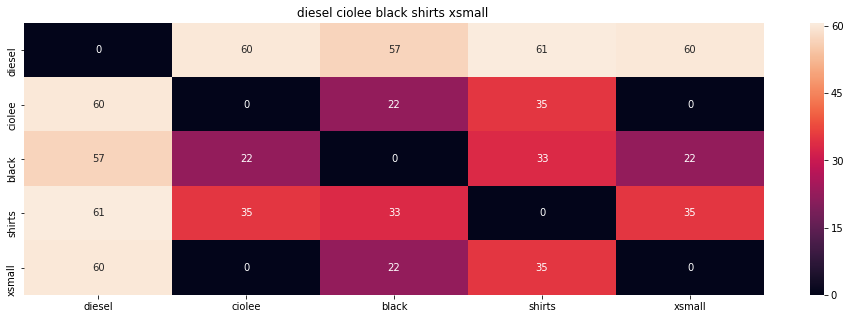

ASIN : B00H7SZTMW
Brand : DIESEL
euclidean distance from input : 0.0


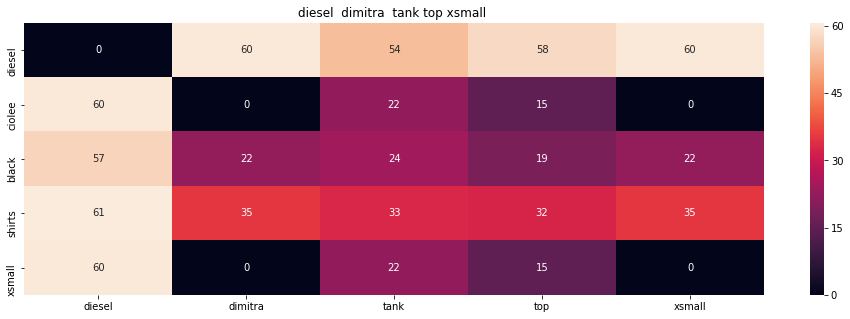

ASIN : B00FS0CUKU
Brand : DIESEL
euclidean distance from input : 14.247082575837954


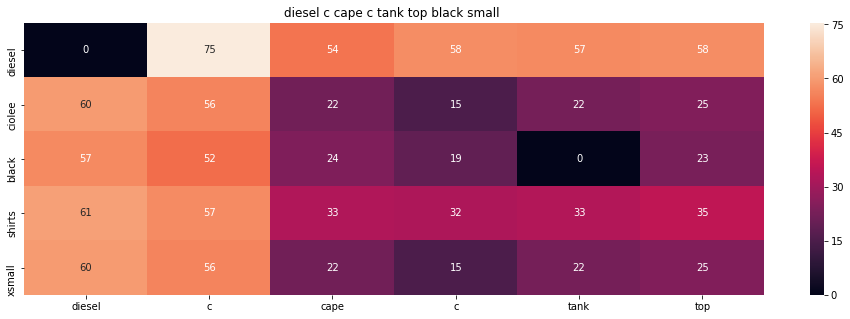

ASIN : B00EZFGE24
Brand : Diesel
euclidean distance from input : 15.511952319533012


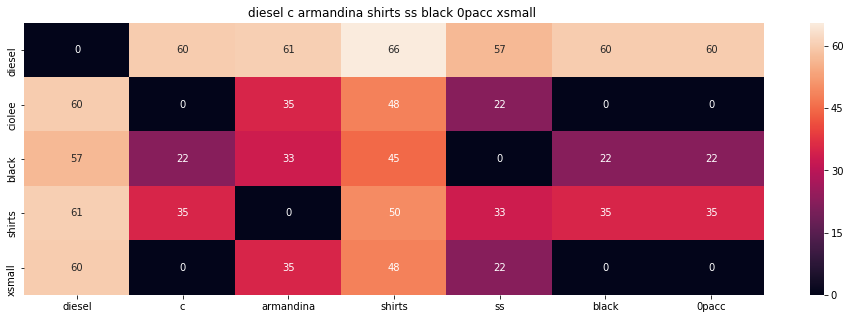

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 15.777611844703411


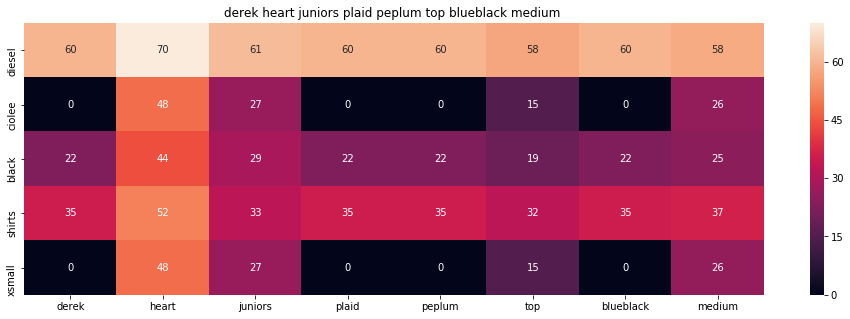

ASIN : B06XF2PVWN
Brand : Derek Heart
euclidean distance from input : 15.90546390031432


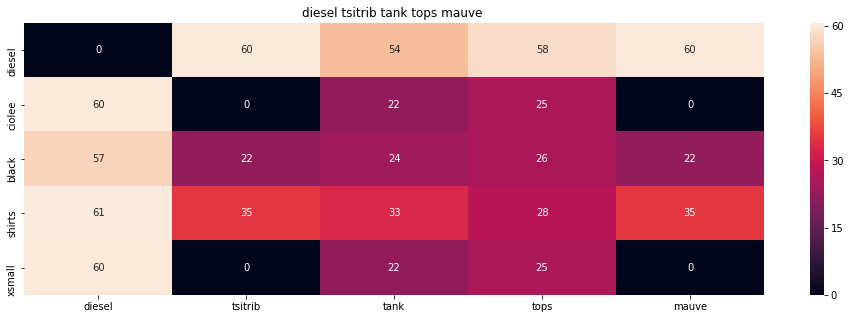

ASIN : B00Y0SO7BG
Brand : Diesel
euclidean distance from input : 15.971537798995707


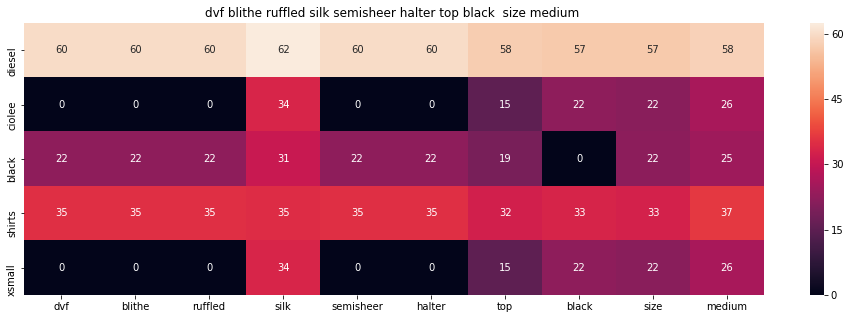

ASIN : B01MQV1KRM
Brand : Diane von Furstenberg
euclidean distance from input : 16.07813435822664


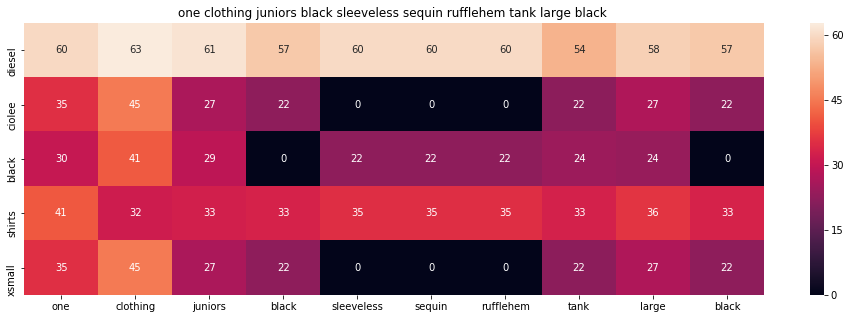

ASIN : B06Y1WFB8R
Brand : One Clothing
euclidean distance from input : 16.15648255425328


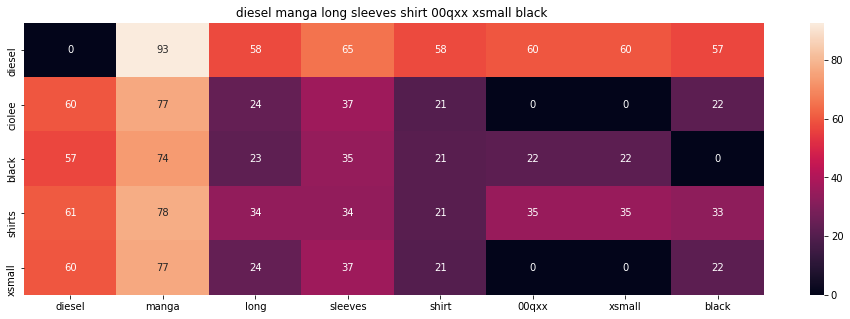

ASIN : B00N2FKJR4
Brand : DIESEL
euclidean distance from input : 16.178657637418002


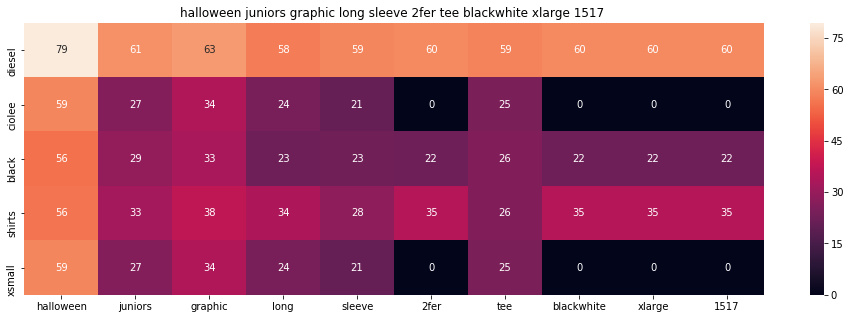

ASIN : B06Y4J3CTP
Brand : Halloween
euclidean distance from input : 16.186939396612722


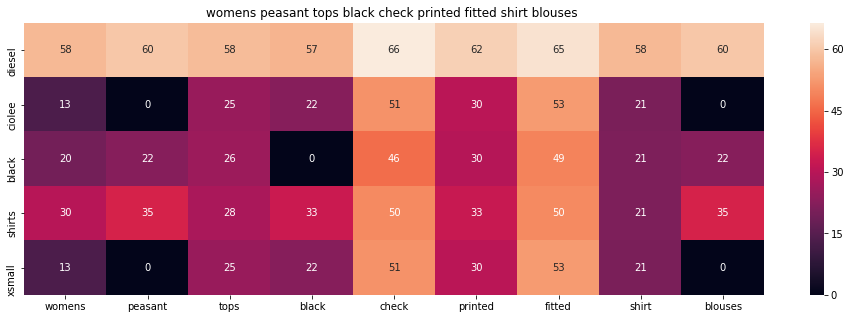

ASIN : B01N53PK9G
Brand : Mogul Interior
euclidean distance from input : 16.23539960569648


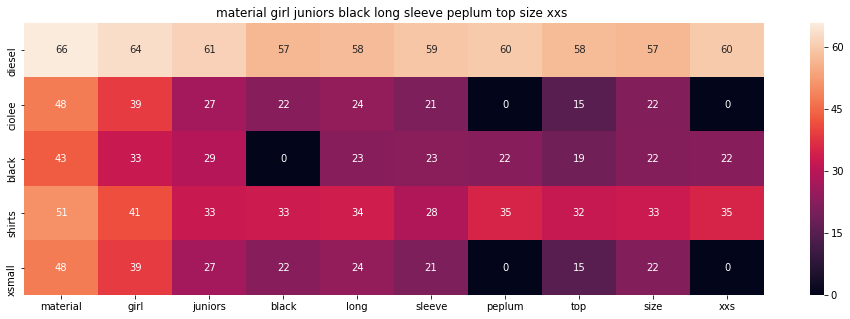

ASIN : B06XSNRDBP
Brand : Material Girl
euclidean distance from input : 16.250075713348945


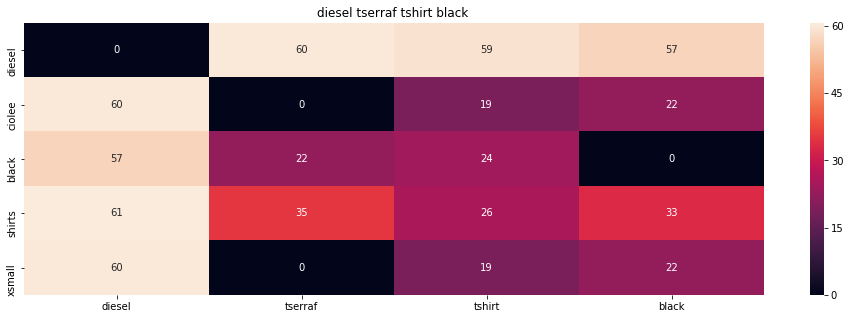

ASIN : B017X8PW9U
Brand : Diesel
euclidean distance from input : 16.299182289919806


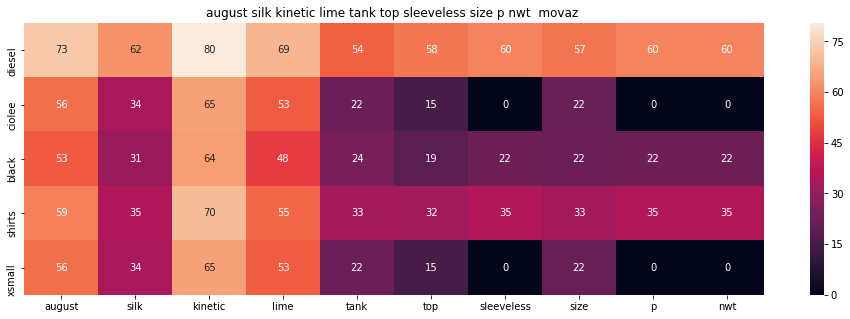

ASIN : B073VXNSM6
Brand : August Silk
euclidean distance from input : 16.30872367947384


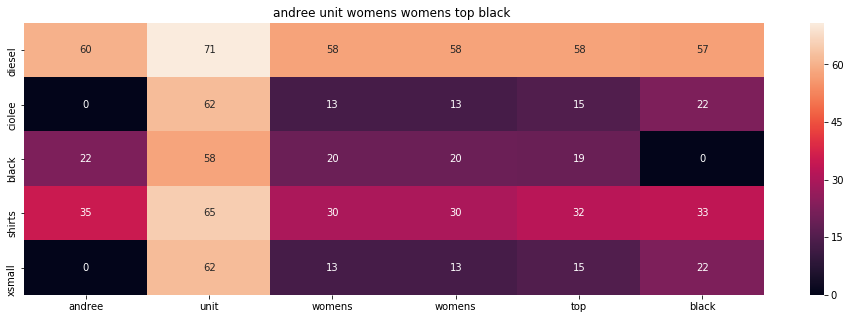

ASIN : B0751GM8FV
Brand : Andree By Unit
euclidean distance from input : 16.318159878164458


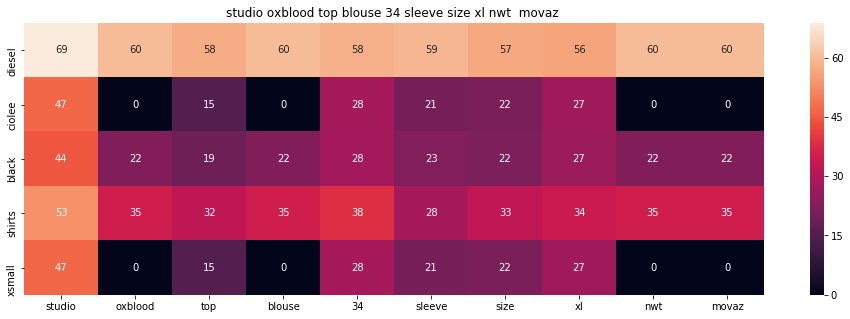

ASIN : B016A8RHZG
Brand : Studio M
euclidean distance from input : 16.418992472175162


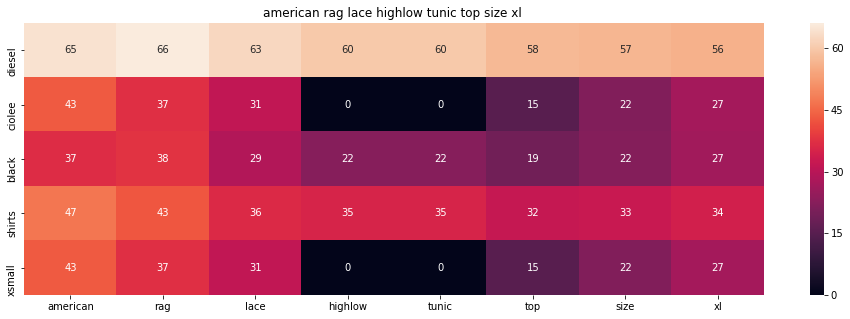

ASIN : B06XY5Z1JB
Brand : American Rag
euclidean distance from input : 16.43183185635449


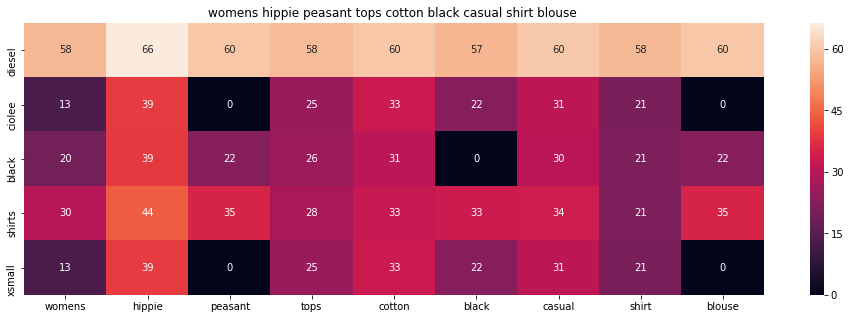

ASIN : B01N2I5VY0
Brand : Mogul Interior
euclidean distance from input : 16.459082696099877


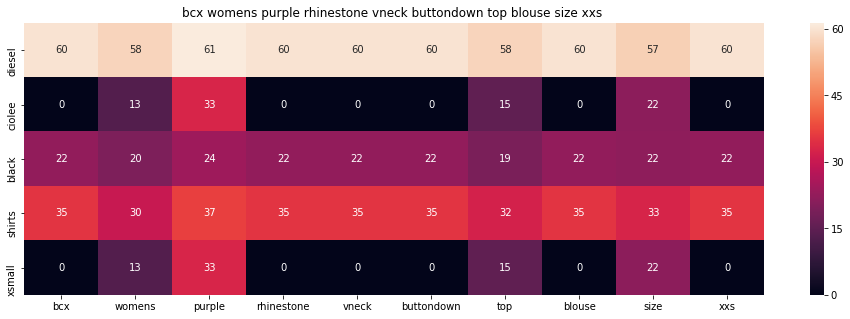

ASIN : B06XRVCNVQ
Brand : BCX
euclidean distance from input : 16.465206751708727


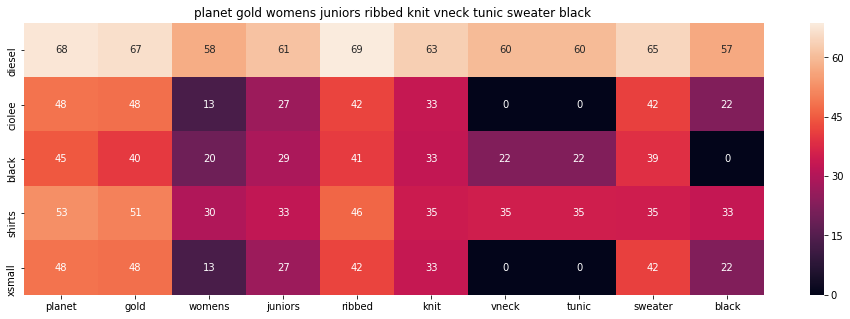

ASIN : B01MQKPKWB
Brand : Planet Gold
euclidean distance from input : 16.466294852385534
Average Distance to all the recommendation = 19.550500487564953


In [88]:
def idf_w2v_brand(doc_id, w_brand, w_color,w_title,w_image, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id].reshape(1,-1))
    color_feat_dist =  pairwise_distances(color_features,color_features[doc_id].reshape(1,-1))
    image_feat_dist = pairwise_distances(image_features,image_features[doc_id].reshape(1,-1))
    pairwise_dist   = (w_title*idf_w2v_dist + w_color*color_feat_dist + w_brand*brand_feat_dist + w_image*image_feat_dist)/float(w_brand + w_color + w_title + w_image)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
    return np.median(pairwise_dist)




avg_dist=idf_w2v_brand(12566, 5, 5, 5, 5, 20)
print("Average Distance to all the recommendation = "+str(avg_dist))

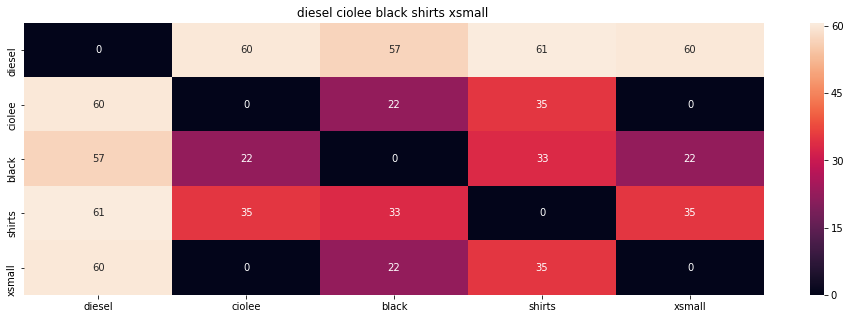

ASIN : B00H7SZTMW
Brand : DIESEL
euclidean distance from input : 0.0


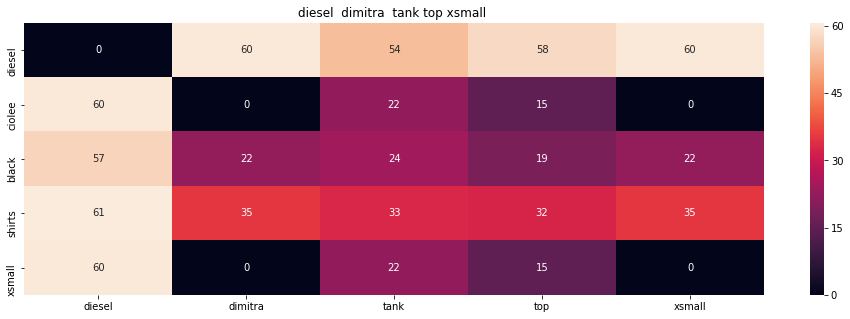

ASIN : B00FS0CUKU
Brand : DIESEL
euclidean distance from input : 4.749027398122742


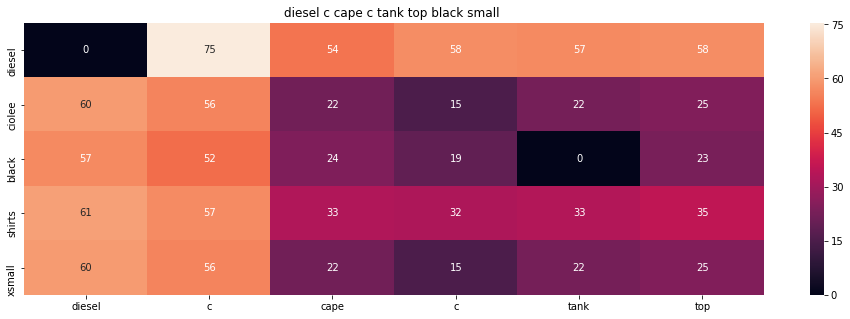

ASIN : B00EZFGE24
Brand : Diesel
euclidean distance from input : 5.170650709599383


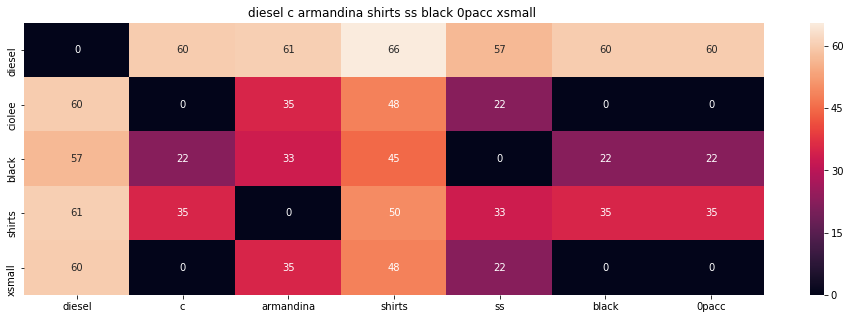

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 5.259203884656183


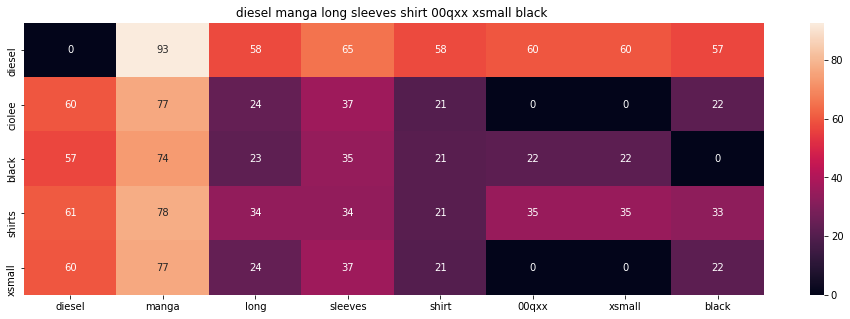

ASIN : B00N2FKJR4
Brand : DIESEL
euclidean distance from input : 5.3928857519827575


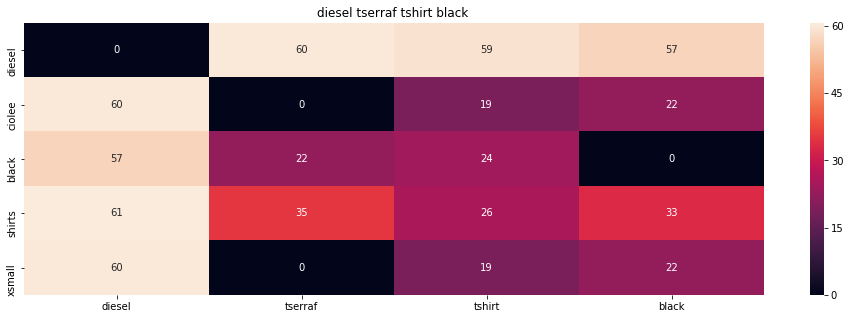

ASIN : B017X8PW9U
Brand : Diesel
euclidean distance from input : 5.433060763306602


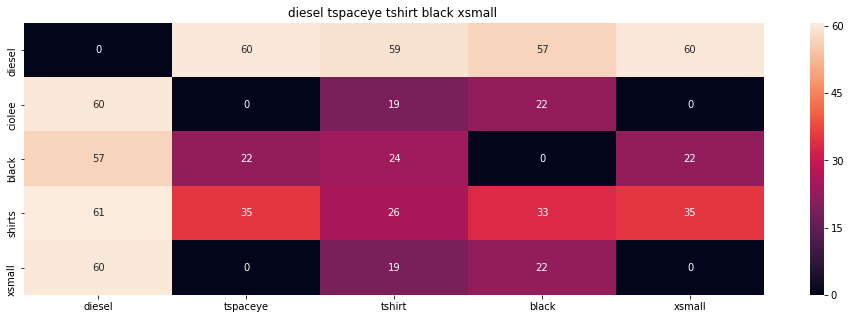

ASIN : B00O8N3U1Q
Brand : DIESEL
euclidean distance from input : 5.489569980109459


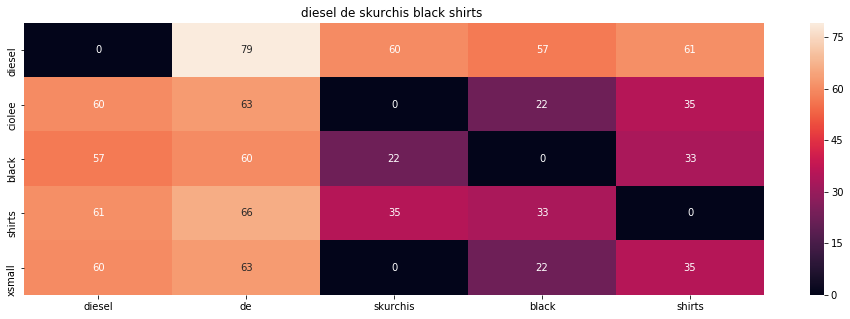

ASIN : B00TPDKXTQ
Brand : Diesel
euclidean distance from input : 5.626896987652735


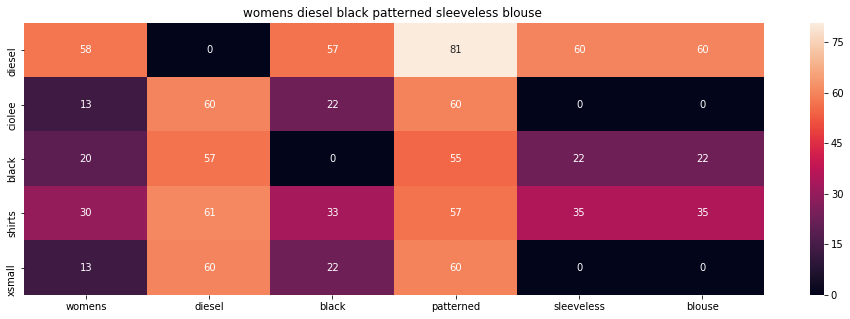

ASIN : B00UM8N8X6
Brand : Diesel
euclidean distance from input : 5.707089854018622


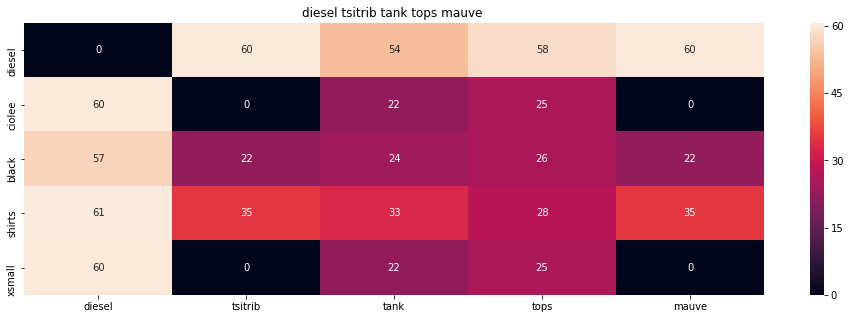

ASIN : B00Y0SO7BG
Brand : Diesel
euclidean distance from input : 5.795250580946175


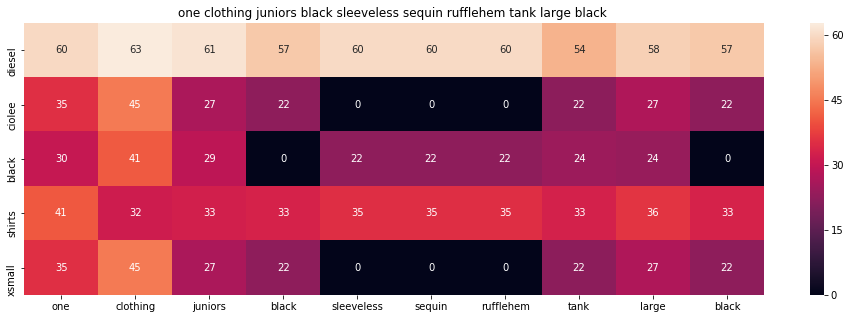

ASIN : B06Y1WFB8R
Brand : One Clothing
euclidean distance from input : 5.962844453940718


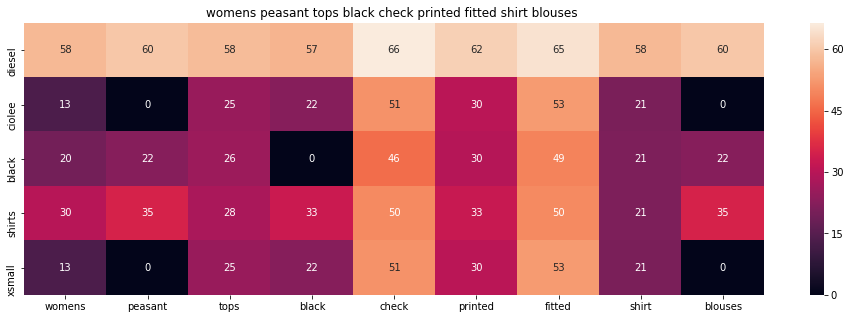

ASIN : B01N53PK9G
Brand : Mogul Interior
euclidean distance from input : 5.989150201333406


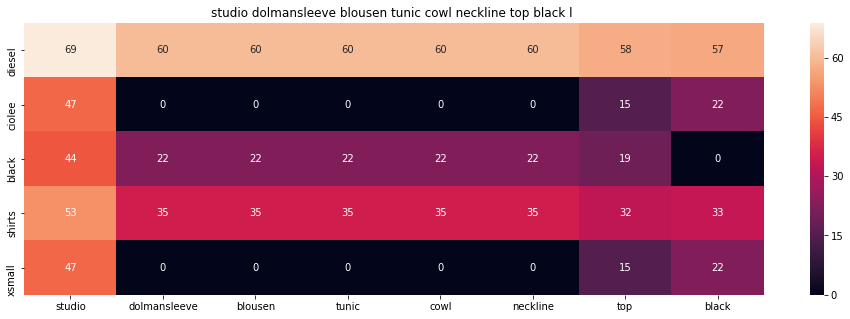

ASIN : B01N369A0Z
Brand : Studio M
euclidean distance from input : 6.0050655153854136


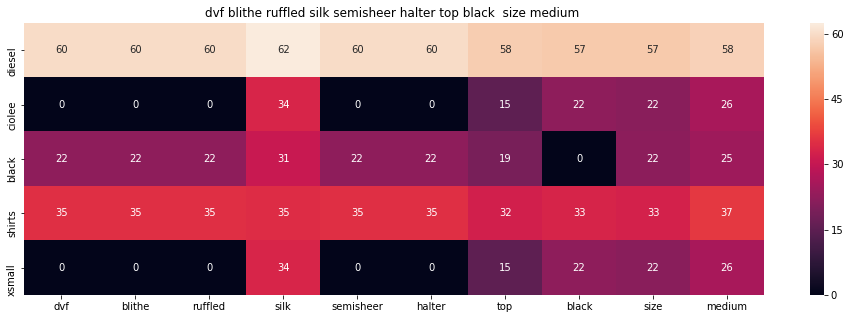

ASIN : B01MQV1KRM
Brand : Diane von Furstenberg
euclidean distance from input : 6.02604472249726


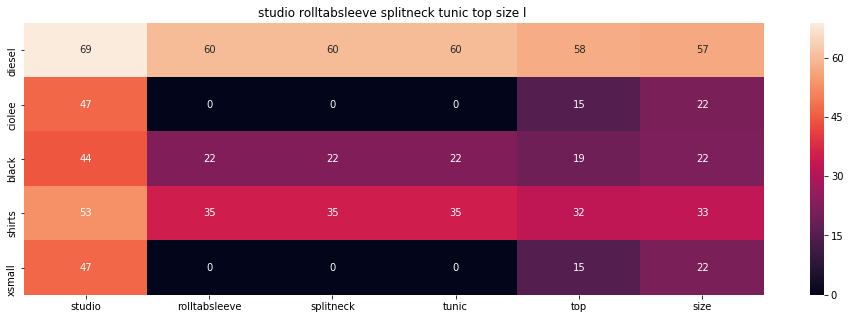

ASIN : B01M5EINF4
Brand : Studio M
euclidean distance from input : 6.038730554548269


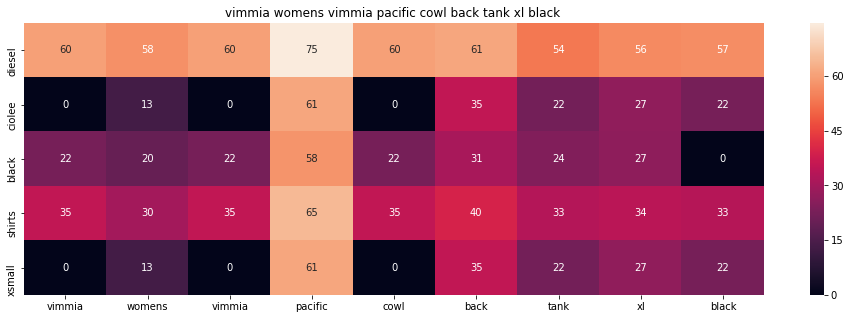

ASIN : B0717997RX
Brand : VIMMIA
euclidean distance from input : 6.048732266282382


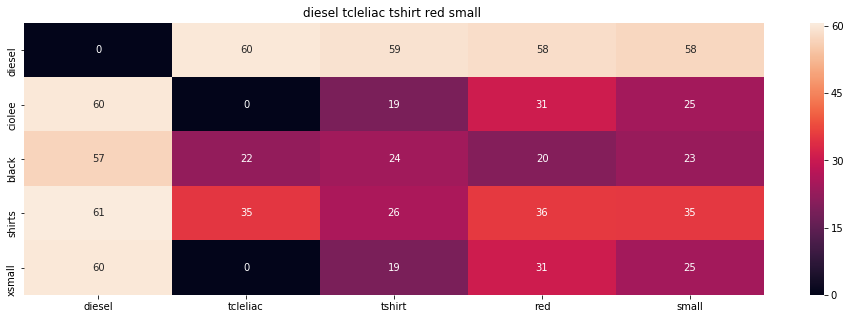

ASIN : B00TSS5GIG
Brand : Diesel
euclidean distance from input : 6.054790748842194


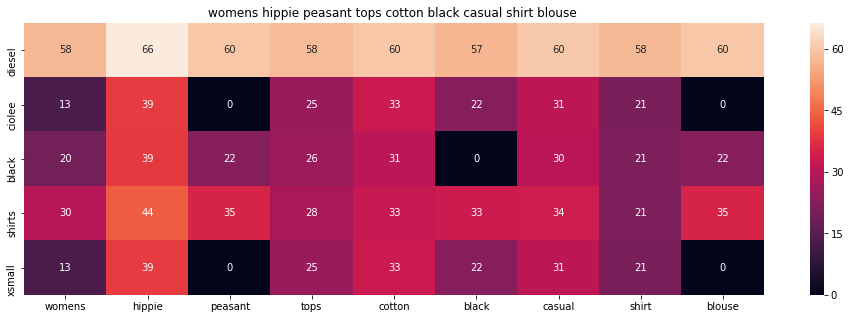

ASIN : B01N2I5VY0
Brand : Mogul Interior
euclidean distance from input : 6.063711167889584


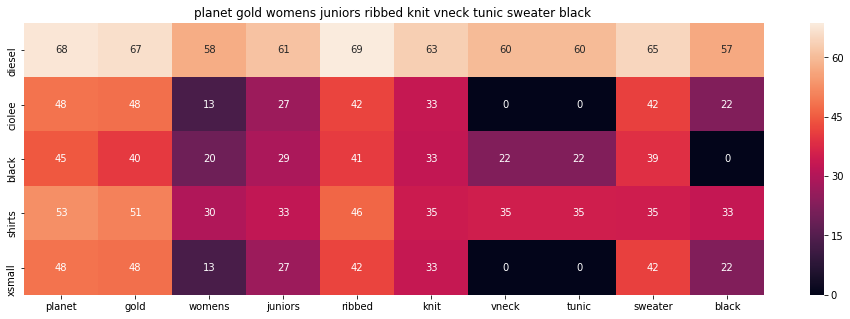

ASIN : B01MQKPKWB
Brand : Planet Gold
euclidean distance from input : 6.06611534714138


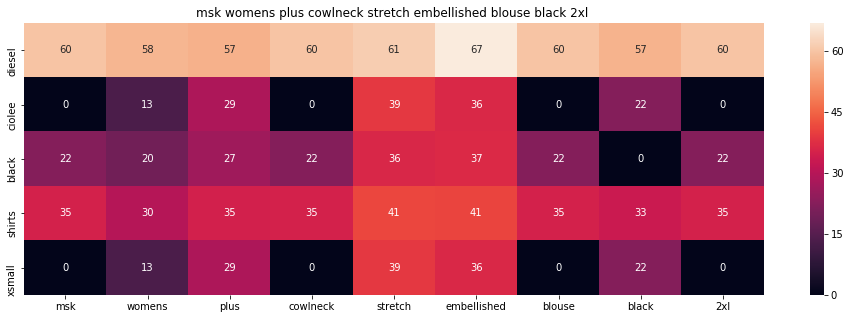

ASIN : B0758G2YBH
Brand : MSK
euclidean distance from input : 6.101633696716783
Average Distance to all the recommendation = 7.504576431174988


In [91]:
avg_dist=idf_w2v_brand(12566, w_brand=5, w_color=5,w_title=1,w_image=1, num_results=20)
print("Average Distance to all the recommendation = "+str(avg_dist))

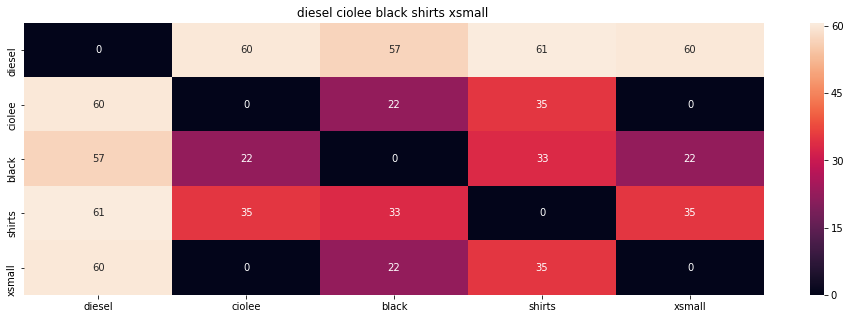

ASIN : B00H7SZTMW
Brand : DIESEL
euclidean distance from input : 0.0


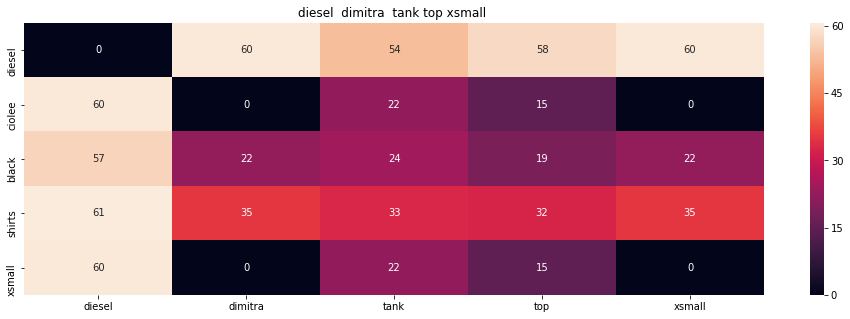

ASIN : B00FS0CUKU
Brand : DIESEL
euclidean distance from input : 23.745137626396588


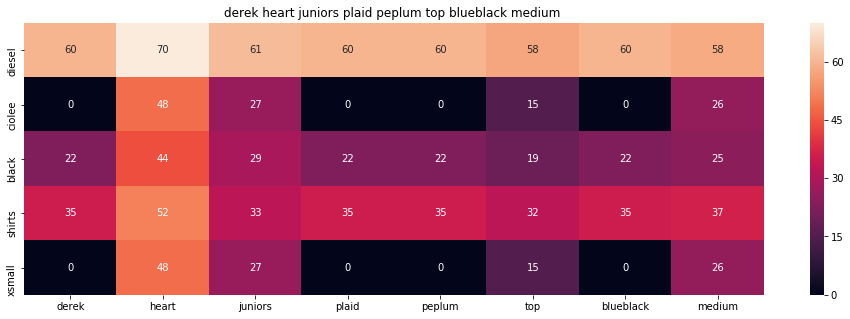

ASIN : B06XF2PVWN
Brand : Derek Heart
euclidean distance from input : 25.598422898000905


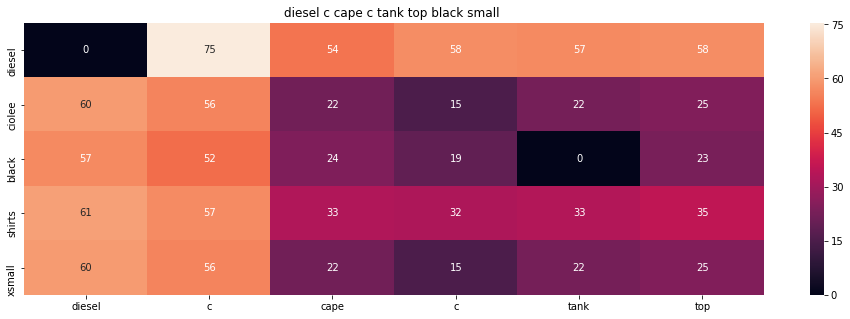

ASIN : B00EZFGE24
Brand : Diesel
euclidean distance from input : 25.85325386588835


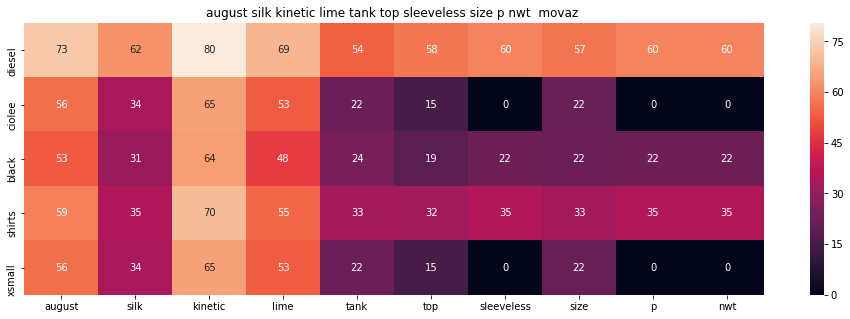

ASIN : B073VXNSM6
Brand : August Silk
euclidean distance from input : 26.02650559407715


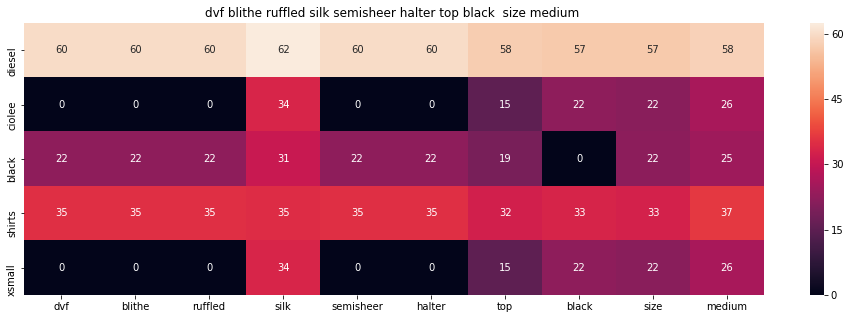

ASIN : B01MQV1KRM
Brand : Diane von Furstenberg
euclidean distance from input : 26.13022393037774


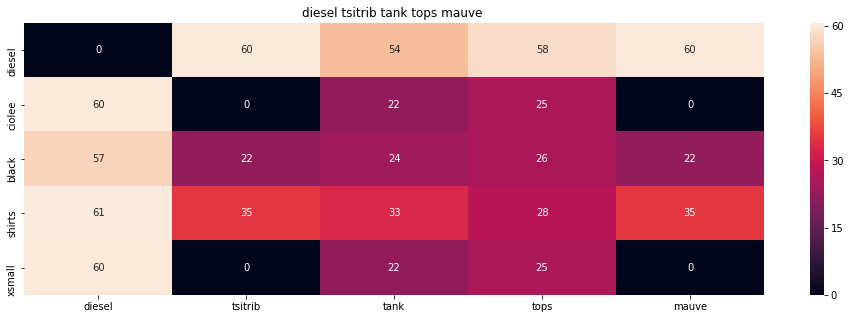

ASIN : B00Y0SO7BG
Brand : Diesel
euclidean distance from input : 26.147825144201807


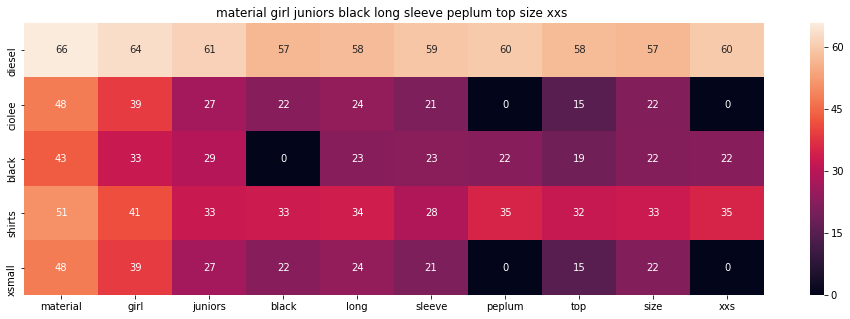

ASIN : B06XSNRDBP
Brand : Material Girl
euclidean distance from input : 26.172775919725282


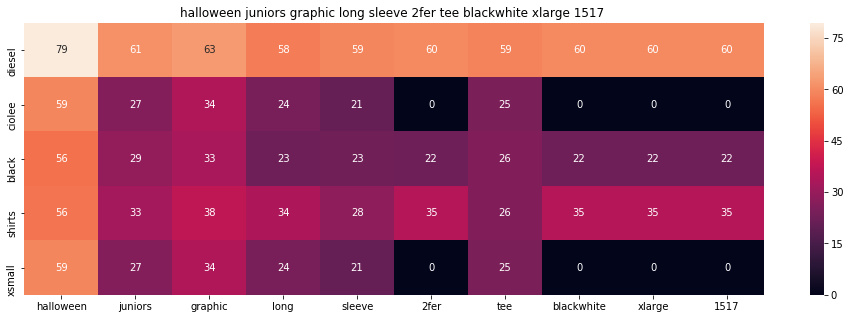

ASIN : B06Y4J3CTP
Brand : Halloween
euclidean distance from input : 26.173494473563505


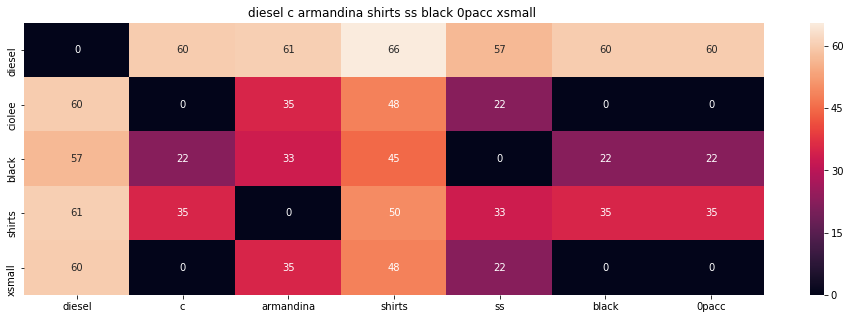

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 26.296019741172355


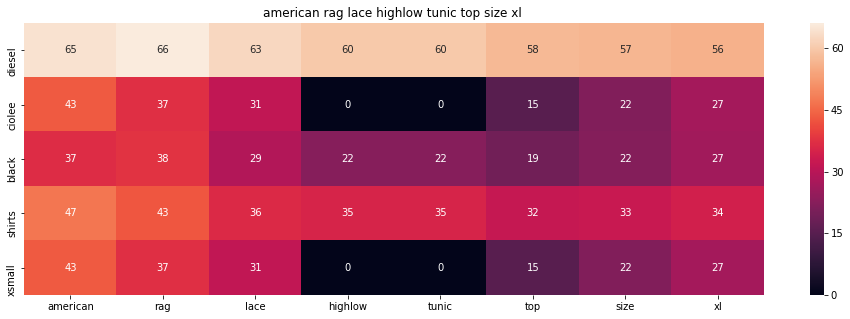

ASIN : B06XY5Z1JB
Brand : American Rag
euclidean distance from input : 26.337631637276825


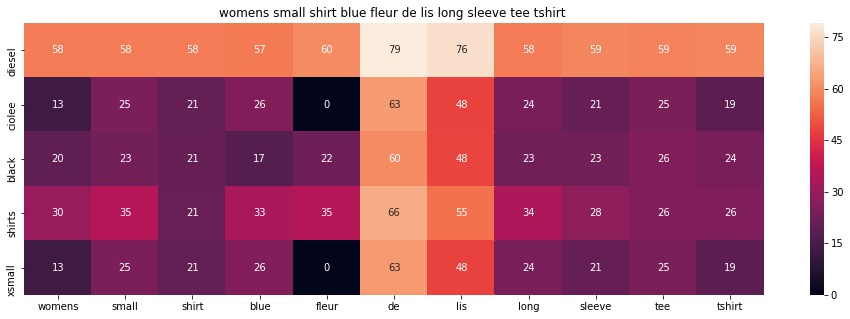

ASIN : B01DICD4ZO
Brand : URBAN X
euclidean distance from input : 26.34312697584096


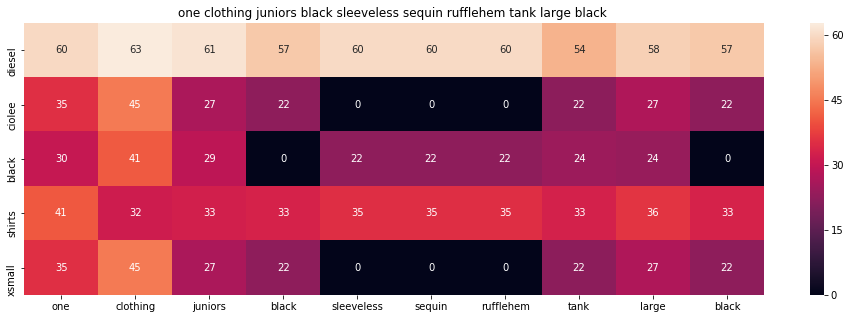

ASIN : B06Y1WFB8R
Brand : One Clothing
euclidean distance from input : 26.35012065456584


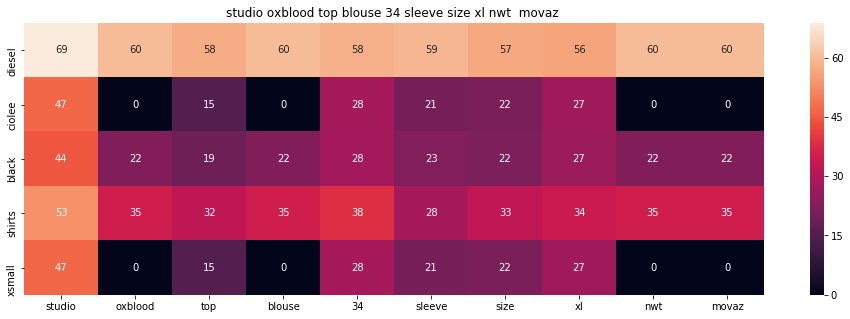

ASIN : B016A8RHZG
Brand : Studio M
euclidean distance from input : 26.422178412043205


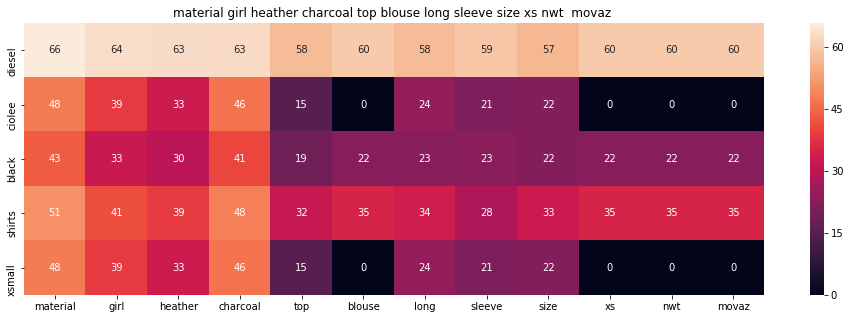

ASIN : B06XXJN73B
Brand : Material Girl
euclidean distance from input : 26.434836328539053


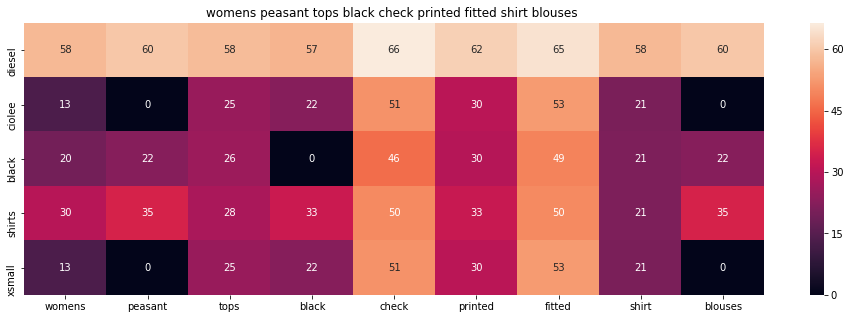

ASIN : B01N53PK9G
Brand : Mogul Interior
euclidean distance from input : 26.48164907363784


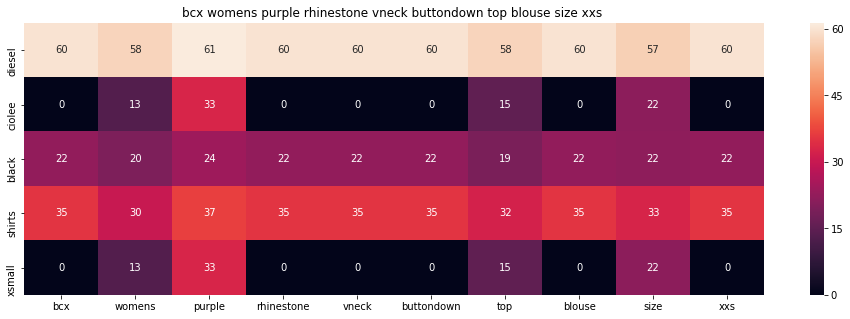

ASIN : B06XRVCNVQ
Brand : BCX
euclidean distance from input : 26.499202211265814


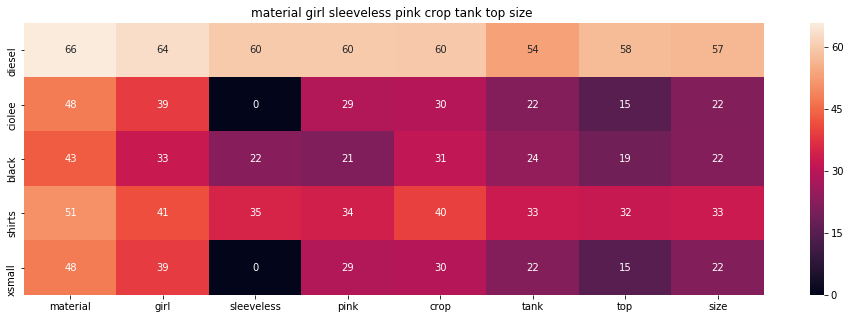

ASIN : B06XY8V9Y5
Brand : Material Girl
euclidean distance from input : 26.502964104677076


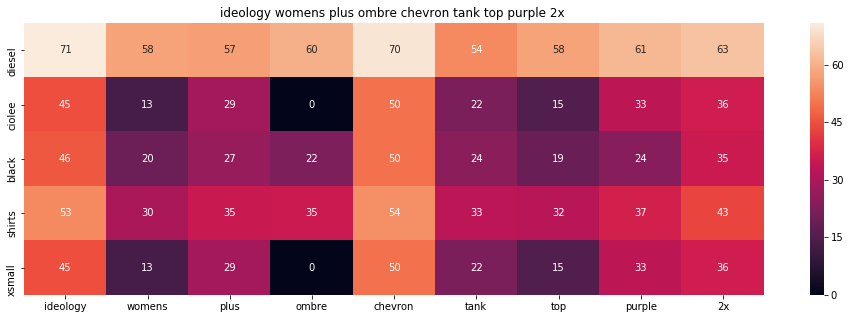

ASIN : B01MZI8MEF
Brand : Ideology
euclidean distance from input : 26.52286973964935


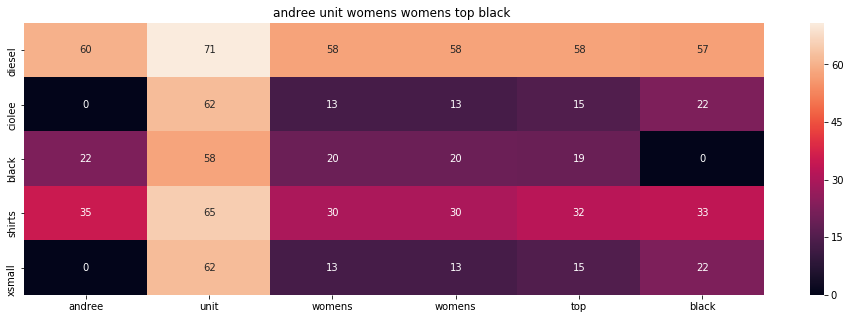

ASIN : B0751GM8FV
Brand : Andree By Unit
euclidean distance from input : 26.530266463607433
Average Distance to all the recommendation = 31.60478557864913


In [98]:
avg_dist=idf_w2v_brand(12566, w_brand=1, w_color=1,w_title=5,w_image=5, num_results=20)
print("Average Distance to all the recommendation = "+str(avg_dist))

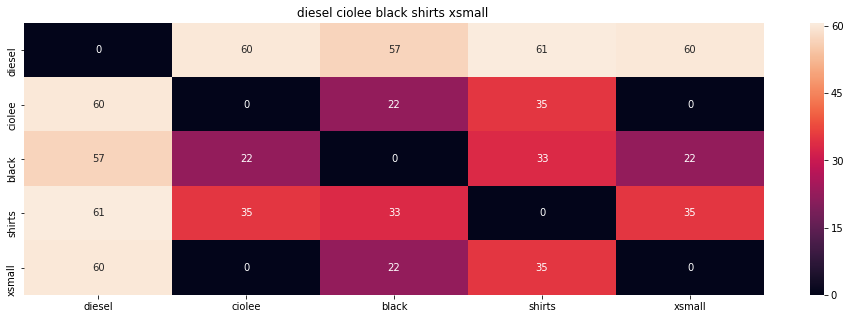

ASIN : B00H7SZTMW
Brand : DIESEL
euclidean distance from input : 0.0


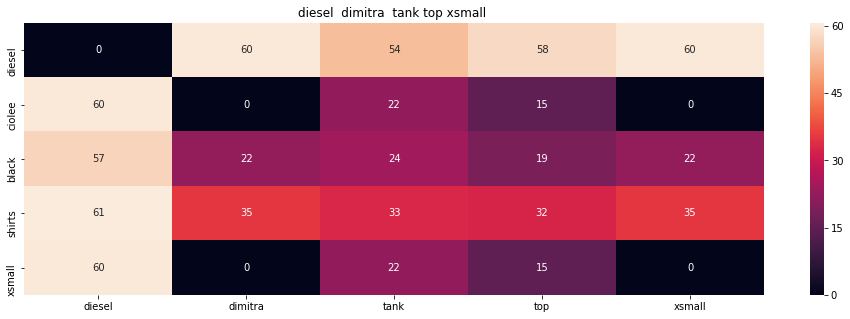

ASIN : B00FS0CUKU
Brand : DIESEL
euclidean distance from input : 14.247082194368225


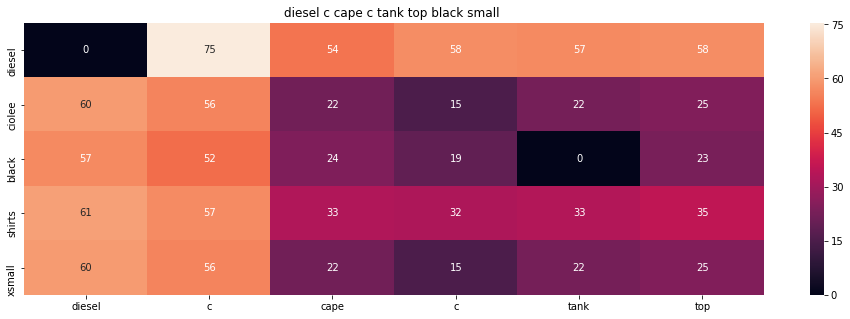

ASIN : B00EZFGE24
Brand : Diesel
euclidean distance from input : 15.511952128798148


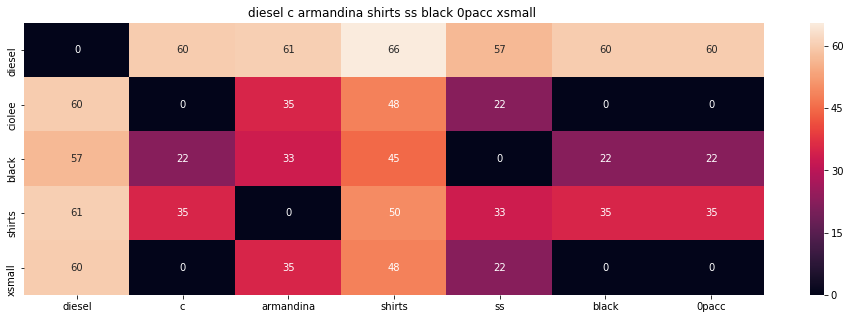

ASIN : B00K6Y3LOM
Brand : DIESEL
euclidean distance from input : 15.777611653968549


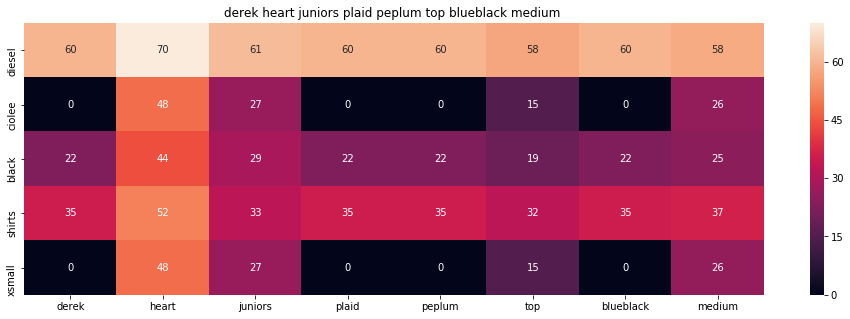

ASIN : B06XF2PVWN
Brand : Derek Heart
euclidean distance from input : 15.90546390031432


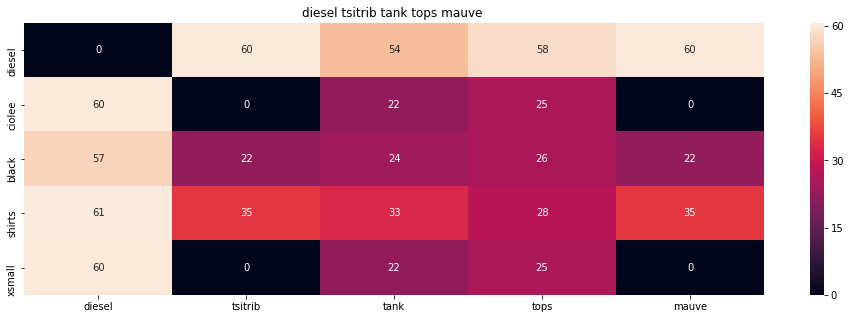

ASIN : B00Y0SO7BG
Brand : Diesel
euclidean distance from input : 15.971538180465432


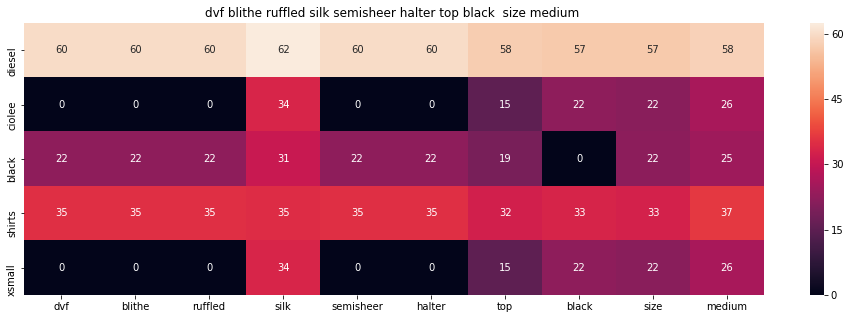

ASIN : B01MQV1KRM
Brand : Diane von Furstenberg
euclidean distance from input : 16.07813416749178


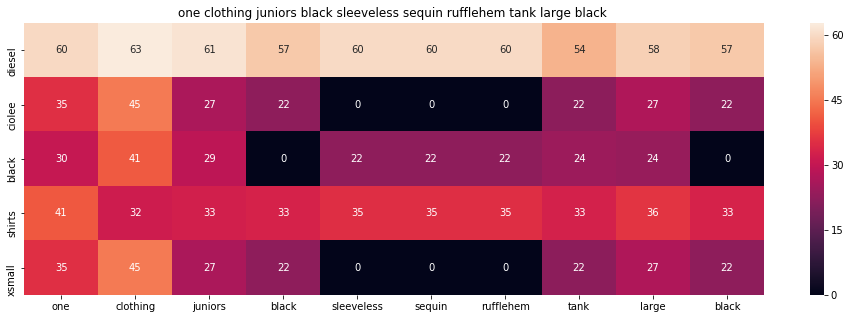

ASIN : B06Y1WFB8R
Brand : One Clothing
euclidean distance from input : 16.15648255425328


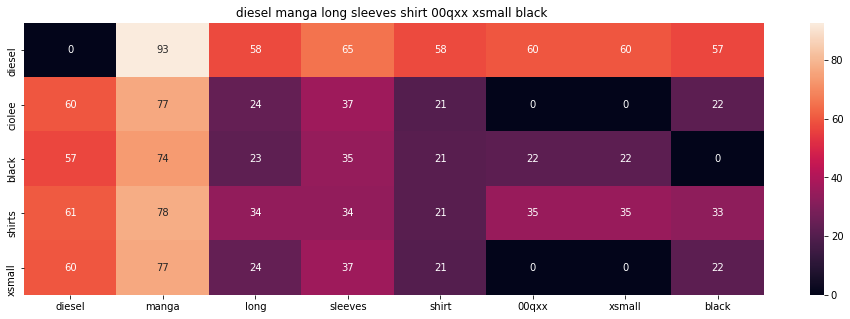

ASIN : B00N2FKJR4
Brand : DIESEL
euclidean distance from input : 16.178657255948274


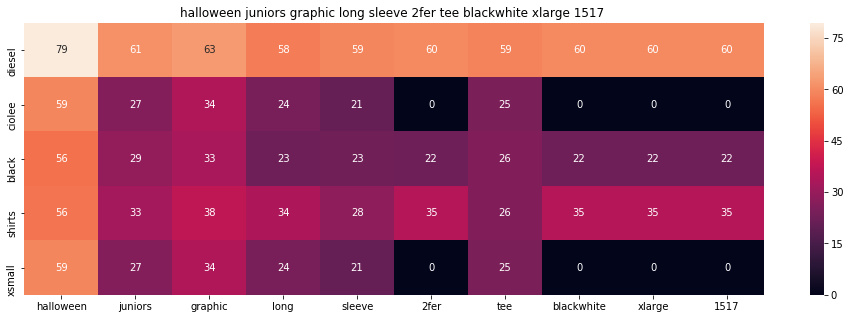

ASIN : B06Y4J3CTP
Brand : Halloween
euclidean distance from input : 16.186939587347585


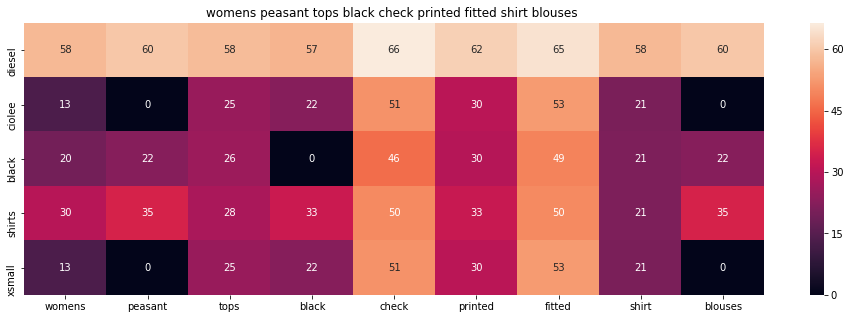

ASIN : B01N53PK9G
Brand : Mogul Interior
euclidean distance from input : 16.23539979643134


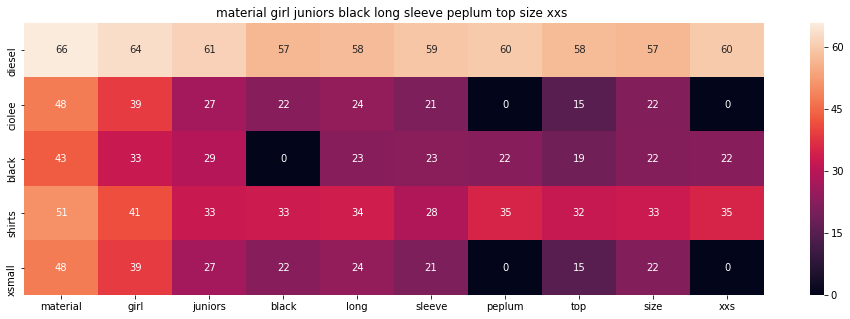

ASIN : B06XSNRDBP
Brand : Material Girl
euclidean distance from input : 16.250075904083808


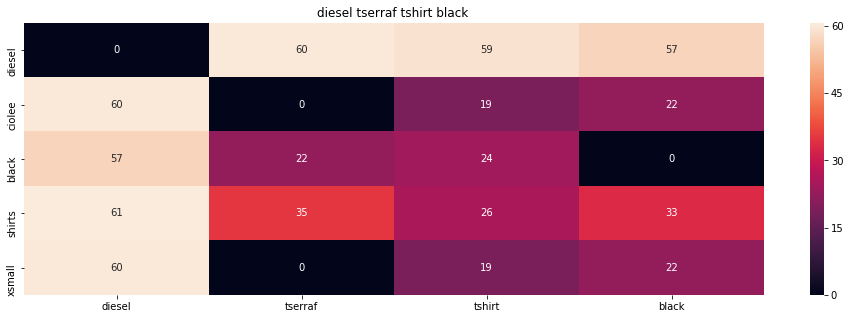

ASIN : B017X8PW9U
Brand : Diesel
euclidean distance from input : 16.299182289919806


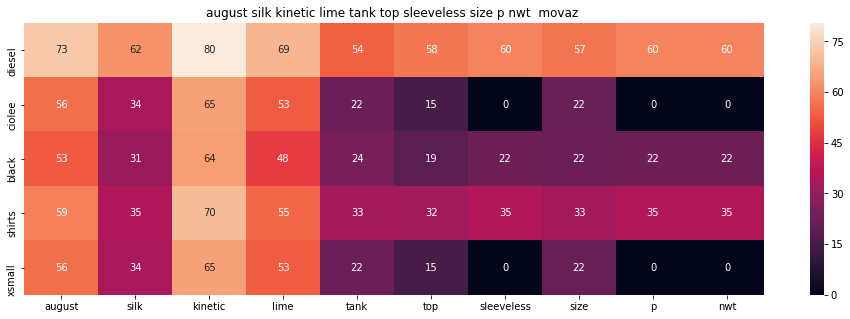

ASIN : B073VXNSM6
Brand : August Silk
euclidean distance from input : 16.308723870208706


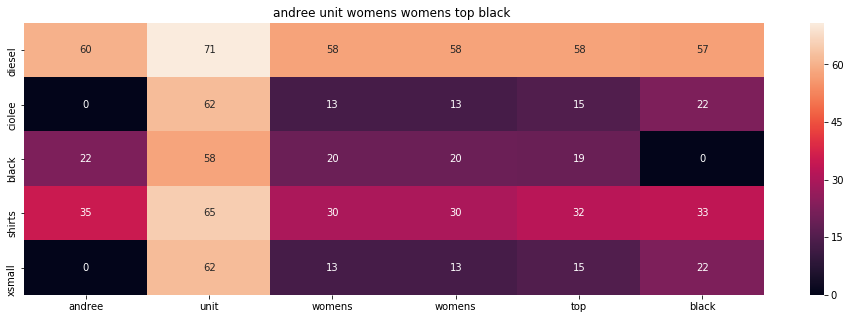

ASIN : B0751GM8FV
Brand : Andree By Unit
euclidean distance from input : 16.31816006889932


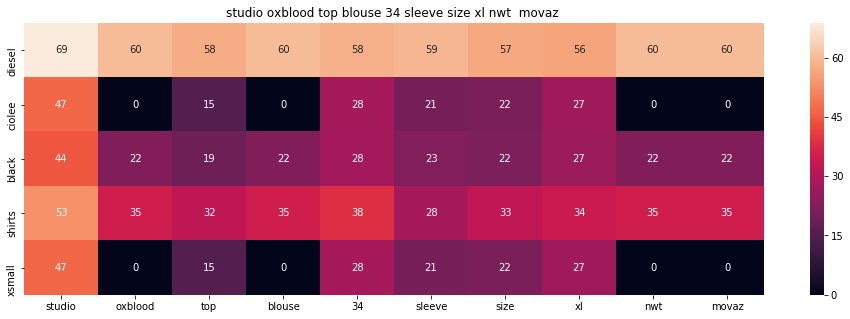

ASIN : B016A8RHZG
Brand : Studio M
euclidean distance from input : 16.4189922814403


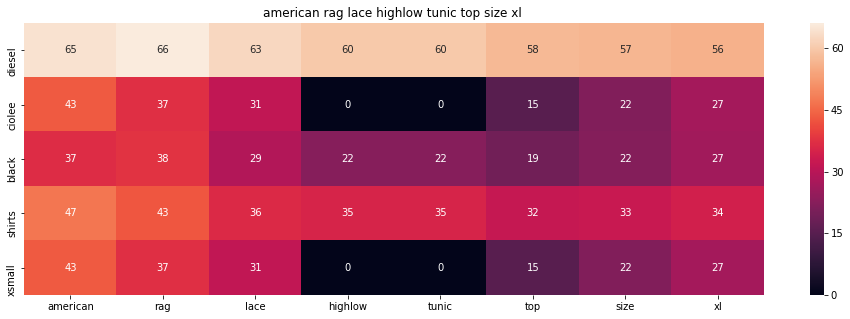

ASIN : B06XY5Z1JB
Brand : American Rag
euclidean distance from input : 16.43183185635449


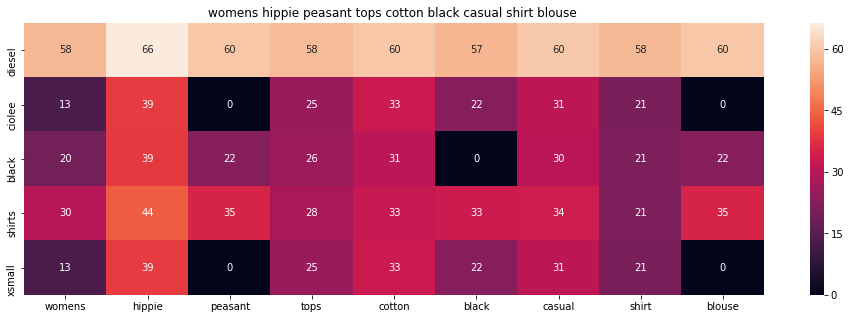

ASIN : B01N2I5VY0
Brand : Mogul Interior
euclidean distance from input : 16.459082696099877


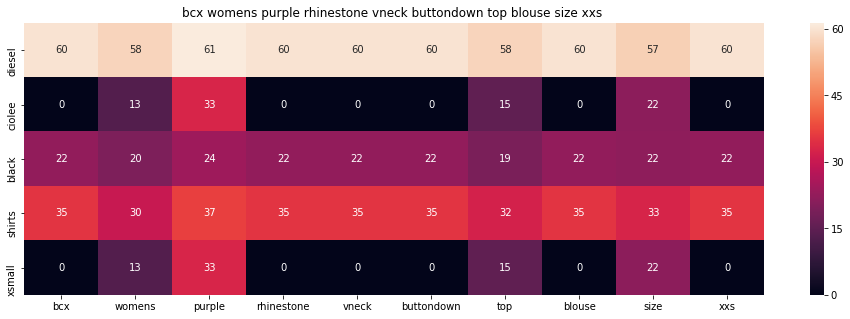

ASIN : B06XRVCNVQ
Brand : BCX
euclidean distance from input : 16.465206560973865


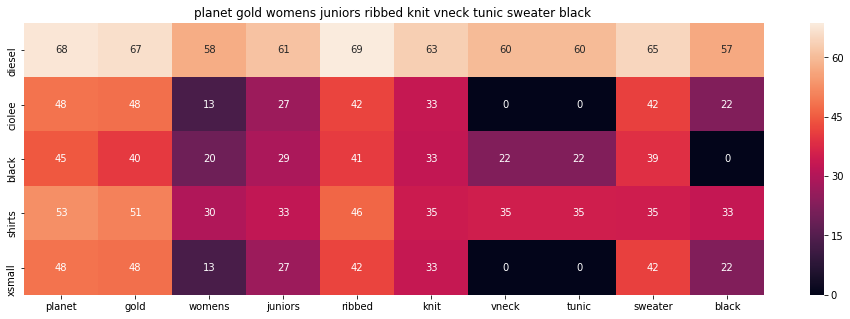

ASIN : B01MQKPKWB
Brand : Planet Gold
euclidean distance from input : 16.466295233855263
Average Distance to all the recommendation = 19.550499724625503


In [99]:
avg_dist=idf_w2v_brand(12566, w_brand=1, w_color=1,w_title=1,w_image=1, num_results=20)
print("Average Distance to all the recommendation = "+str(avg_dist))

# Step that Follow:<br>
1.Preprocessed all the text data.<br>
2.Vectorization of brand,color,title,image features.<br>
3.Find the pairwise distance considering all the feature vector.<br>
4.Concated with their weight.<br>
5.Find top 20 recommeded clothes.

In [100]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names = ["Model", "Brand Weight ", "Color Weight", "Title Weight","Image Weight","Average Distance"]

x.add_row(["1","5", "5", "5","5"," 19.55"])
x.add_row(["2","5", "5", "1","1","7.50 "])
x.add_row(["3","1", "1", "5","5"," 31.60"])
x.add_row(["1","1", "1", "1","1","19.55"])
print(x)

+-------+---------------+--------------+--------------+--------------+------------------+
| Model | Brand Weight  | Color Weight | Title Weight | Image Weight | Average Distance |
+-------+---------------+--------------+--------------+--------------+------------------+
|   1   |       5       |      5       |      5       |      5       |       19.55      |
|   2   |       5       |      5       |      1       |      1       |      7.50        |
|   3   |       1       |      1       |      5       |      5       |       31.60      |
|   1   |       1       |      1       |      1       |      1       |      19.55       |
+-------+---------------+--------------+--------------+--------------+------------------+
